bluestore_lat_simple 0.090071 , simple_start 2020-05-18T23:03:18.421099-0500
bluestore_lat_simple 0.0928 , simple_start 2020-05-18T23:03:18.421109-0500
bluestore_lat_simple 0.092813 , simple_start 2020-05-18T23:03:18.421112-0500
bluestore_lat_simple 0.092677 , simple_start 2020-05-18T23:03:18.421261-0500
bluestore_lat_simple 0.092678 , simple_start 2020-05-18T23:03:18.421271-0500
bluestore_lat_simple 0.092668 , simple_start 2020-05-18T23:03:18.421291-0500
bluestore_lat_simple 0.09265 , simple_start 2020-05-18T23:03:18.421344-0500
bluestore_lat_simple 0.092641 , simple_start 2020-05-18T23:03:18.421364-0500
bluestore_lat_simple 0.092617 , simple_start 2020-05-18T23:03:18.421397-0500
bluestore_lat_simple 0.092585 , simple_start 2020-05-18T23:03:18.421441-0500
bluestore_lat_simple 0.092585 , simple_start 2020-05-18T23:03:18.421447-0500
bluestore_lat_simple 0.092596 , simple_start 2020-05-18T23:03:18.421446-0500
bluestore_lat_simple 0.092599 , simple_start 2020-05-18T23:03:18.421454-0500
bl

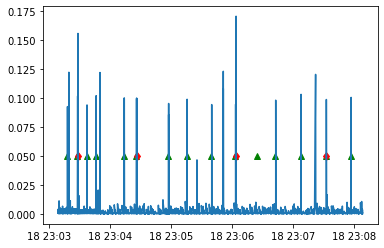

In [1]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt

utc=pytz.UTC # work with offset-naive and offset-aware datetimes

f1='dump_time_stamps_vec.csv'
data1=read_csv(f1, skiprows=10000, parse_dates=True, squeeze=True, sep=',', header=None)
datalen = len(data1.values)

def check_bracket(str):
    if str == None:
        return "0"
    if str.startswith('['):
        return str[1:]
    if str.endswith(']'):
        return str[:-1]
    return str

# for bluestore latency
x_bs_lat = []
y_bs_lat = []


# process the time stamps
for i in range(datalen-1):
    # simple writes
    #if len(data1.values[i,:]) == len(data1.values[i+1,:]) and data1.values[i,2] == 'simple_s':
    if data1.values[i,2] == 'simple_s':
        # for first ctx
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        simple_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        aio_done1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        simple_e1 = parser.parse(check_bracket(data1.values[i,11])).replace(tzinfo=utc)
        # for second ctx
        '''ctr_ctx2 = parser.parse(check_bracket(data1.values[i+1,1]))
        simple_s2 = parser.parse(check_bracket(data1.values[i+1,3]))
        aio_done2 = parser.parse(check_bracket(data1.values[i+1,5]))
        flush_cmt_s2 = parser.parse(check_bracket(data1.values[i+1,7]))
        flush_cmt_e2 = parser.parse(check_bracket(data1.values[i+1,9]))
        simple_e2 = parser.parse(check_bracket(data1.values[i+1,11]))'''
        # sanity check of timestamps
        if simple_s1 < ctr_ctx1 or aio_done1 < simple_s1 or flush_cmt_s1 < aio_done1 or flush_cmt_e1 < flush_cmt_s1 or simple_e1 < flush_cmt_e1:
            print("simple writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_simple = simple_e1 - simple_s1
        x_bs_lat.append(simple_s1)
        y_bs_lat.append(bluestore_lat_simple.total_seconds())
        
        # spikes
        if bluestore_lat_simple.total_seconds() > 0.05:
            print("bluestore_lat_simple",bluestore_lat_simple.total_seconds(),", simple_start",check_bracket(data1.values[i,3]))

    # deferred writes
    elif data1.values[i,2] == 'deferred_s':
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        deferred_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        deferred_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        # sanity check of timestamps
        if deferred_s1 < ctr_ctx1 or flush_cmt_s1 < deferred_s1 or flush_cmt_e1 < flush_cmt_s1 or deferred_e1 < flush_cmt_e1:
            print("deferred writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_deferred = deferred_e1 - deferred_s1
        x_bs_lat.append(deferred_s1)
        y_bs_lat.append(bluestore_lat_deferred.total_seconds())
        
        # spikes
        if bluestore_lat_deferred.total_seconds() > 0.05:
            print("bluestore_lat_deferred",bluestore_lat_deferred.total_seconds(),", deferred_start",check_bracket(data1.values[i,3]))

if2='flush_job_timestamps.csv'     # Compaction for L0
if3='compact_job_timestamps.csv'   # Compaction for other levels
id2=read_csv(if2, parse_dates=True, squeeze=True, sep=',', header=None)
id3=read_csv(if3, parse_dates=True, squeeze=True, sep=',', header=None)

id2len = len(id2.values)
id3len = len(id3.values)

x2_compact = [] # flush(L0) timestamps
x3_compact = [] # compact(>= L1) timestamps
y2_compact = [] # dummp y value
y3_compact = [] # dummp y value
w2_compact = [] # durations(width of compaction)
w3_compact = [] # durations(width of compaction)

for i in range(id2len):
    x2_compact.append((parser.parse(id2.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w2_compact.append(id2.values[i,5]/1000000)
    y2_compact.append(0.05)
for i in range(id3len):
    x3_compact.append((parser.parse(id3.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w3_compact.append(id3.values[i,5]/1000000)
    y3_compact.append(0.05)


plt.plot(x2_compact, y2_compact, label='4096 KiB',marker='^', c='g', linestyle='')
plt.plot(x3_compact, y3_compact, label='4096 KiB',marker='d', c='r', linestyle='')
         
plt.plot(x_bs_lat, y_bs_lat, label='bluestore')
#ax.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series')
#plt.legend()
plt.show()
plt.close()